# Entities:
* Claim
* Beneficiary
* Physician
* Provider

# Edges
* Provider <-> Claim
* Provider <-> Physician
* Provider <-> Beneficiary

In [ ]:
import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
#####################
# TABULAR DATA PREP #
#####################

def create_agg_feats(grp_col, feat_name, operation='sum'):
    """
    Description :: This function is created for adding the aggregated features in the dataset for every level like:
        - Beneficiary
        - Attending Physician
        - Operating Physician
        - Other Physician and etc..
        
    Input Parameters :: It accepts below inputs:
        - grp_col : `str`
            - It represents the feature or level at which you want to perform the aggregation.
        
        - feat_name : `str`
            - It represents the feature whose aggregated aspect you want to capture.
        
        - operation : `str`
            - It represents the aggregation operation you want to perform.(By default it is SUM)
    """
    feat_1 = feat_name + "_Insc_ReImb_Amt"
    train_iobp_df[feat_1] = train_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)

    feat_2 = feat_name + "_CoPayment"
    train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)

    feat_3 = feat_name + "_IP_Annual_ReImb_Amt"
    train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)

    feat_4 = feat_name + "_IP_Annual_Ded_Amt"
    train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)

    feat_5 = feat_name + "_OP_Annual_ReImb_Amt"
    train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)

    feat_6 = feat_name + "_OP_Annual_Ded_Amt"
    train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)

    feat_7 = feat_name + "_Admit_Duration"
    train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)

    feat_8 = feat_name + "_Claim_Duration"
    train_iobp_df[feat_8] = train_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)

# Load the data
train_bene_df = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")
train_ip_df = pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")
train_op_df = pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")
train_tgt_lbls_df = pd.read_csv("data/Train-1542865627584.csv")

# Add the target labels to the inpatient and outpatient dataframes
train_ip_df["Admitted?"] = 1
train_op_df["Admitted?"] = 0

# Commom columns must be 28
common_cols = [col for col in train_ip_df.columns if col in train_op_df.columns]

# Merging the IP and OP dataset on the basis of common columns
train_ip_op_df = pd.merge(left=train_ip_df, right=train_op_df, left_on=common_cols, right_on=common_cols, how="outer")

# Joining the IP_OP dataset with the BENE data
train_ip_op_bene_df = pd.merge(left=train_ip_op_df, right=train_bene_df, left_on='BeneID', right_on='BeneID',how='inner')

# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
train_iobp_df = pd.merge(left=train_ip_op_bene_df, right=train_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')

train_iobp_df['DOB'] = pd.to_datetime(train_iobp_df['DOB'], format="%Y-%m-%d")
train_iobp_df['DOD'] = pd.to_datetime(train_iobp_df['DOD'], format="%Y-%m-%d")
train_iobp_df['Is_Alive?'] = train_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')
train_iobp_df['ClaimStartDt'] = pd.to_datetime(train_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
train_iobp_df['ClaimEndDt'] = pd.to_datetime(train_iobp_df['ClaimEndDt'], format="%Y-%m-%d")
train_iobp_df['Claim_Duration'] = (train_iobp_df['ClaimEndDt'] - train_iobp_df['ClaimStartDt']).dt.days
train_iobp_df['AdmissionDt'] = pd.to_datetime(train_iobp_df['AdmissionDt'], format="%Y-%m-%d")
train_iobp_df['DischargeDt'] = pd.to_datetime(train_iobp_df['DischargeDt'], format="%Y-%m-%d")
train_iobp_df['Admitted_Duration'] = (train_iobp_df['DischargeDt'] - train_iobp_df['AdmissionDt']).dt.days

# Filling the Null values as MAX Date of Death in the Dataset
train_iobp_df['DOD'].fillna(value=train_iobp_df['DOD'].max(), inplace=True)
train_iobp_df['Bene_Age'] = round(((train_iobp_df['DOD'] - train_iobp_df['DOB']).dt.days)/365,1)
train_iobp_df['Att_Phy_tot_claims'] = train_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Opr_Phy_tot_claims'] = train_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Oth_Phy_tot_claims'] = train_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')

# Creating the combined feature
train_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = train_iobp_df['Att_Phy_tot_claims'] + train_iobp_df['Opr_Phy_tot_claims'] + train_iobp_df['Oth_Phy_tot_claims']
train_iobp_df.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)
train_iobp_df["Prv_Tot_Att_Phy"] = train_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Opr_Phy"] = train_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Oth_Phy"] = train_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')
train_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = train_iobp_df['Prv_Tot_Att_Phy'] + train_iobp_df['Prv_Tot_Opr_Phy'] + train_iobp_df['Prv_Tot_Oth_Phy']
train_iobp_df.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)
train_iobp_df['PRV_Tot_Admit_DCodes'] = train_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')
train_iobp_df['PRV_Tot_DGrpCodes'] = train_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')
train_iobp_df['DOB_Year'] = train_iobp_df['DOB'].dt.year
train_iobp_df['PRV_Tot_Unq_DOB_Years'] = train_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')
train_iobp_df.drop(['DOB_Year'], axis=1, inplace=True)
train_iobp_df['PRV_Bene_Age_Sum'] = train_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = train_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')
train_iobp_df['RenalDiseaseIndicator'] = train_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)
train_iobp_df['PRV_Tot_RKD_Patients'] = train_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')

# Dropping these 2 columns as there 99% of values are same
train_iobp_df.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], axis=1, inplace=True)

# Filling null values in Admitted_Duration with 0 (as it will represent the patients were admitted for 0 days)
train_iobp_df['Admitted_Duration'].fillna(value=0,inplace=True)

# PRV Aggregate features
train_iobp_df["PRV_CoPayment"] = train_iobp_df.groupby('Provider')['DeductibleAmtPaid'].transform('sum')
train_iobp_df["PRV_IP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_IP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_Admit_Duration"] = train_iobp_df.groupby('Provider')['Admitted_Duration'].transform('sum')
train_iobp_df["PRV_Claim_Duration"] = train_iobp_df.groupby('Provider')['Claim_Duration'].transform('sum')

# BENE, PHYs, Diagnosis Admit and Group Codes columns
create_agg_feats(grp_col='BeneID', feat_name="BENE")
create_agg_feats(grp_col='AttendingPhysician', feat_name="ATT_PHY")
create_agg_feats(grp_col='OperatingPhysician', feat_name="OPT_PHY")
create_agg_feats(grp_col='OtherPhysician', feat_name="OTH_PHY")
create_agg_feats(grp_col='ClmAdmitDiagnosisCode', feat_name="Claim_Admit_Diag_Code")
create_agg_feats(grp_col='DiagnosisGroupCode', feat_name="Diag_GCode")

# Dropping these 3 columns as there 99% of values are same
train_iobp_df.drop(['ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis=1, inplace=True)

# Diagnosis Codes columns
create_agg_feats(grp_col='ClmDiagnosisCode_1', feat_name="Claim_DiagCode1")
create_agg_feats(grp_col='ClmDiagnosisCode_2', feat_name="Claim_DiagCode2")
create_agg_feats(grp_col='ClmDiagnosisCode_3', feat_name="Claim_DiagCode3")
create_agg_feats(grp_col='ClmDiagnosisCode_4', feat_name="Claim_DiagCode4")
create_agg_feats(grp_col='ClmDiagnosisCode_5', feat_name="Claim_DiagCode5")
create_agg_feats(grp_col='ClmDiagnosisCode_6', feat_name="Claim_DiagCode6")
create_agg_feats(grp_col='ClmDiagnosisCode_7', feat_name="Claim_DiagCode7")
create_agg_feats(grp_col='ClmDiagnosisCode_8', feat_name="Claim_DiagCode8")
create_agg_feats(grp_col='ClmDiagnosisCode_9', feat_name="Claim_DiagCode9")
create_agg_feats(grp_col='ClmDiagnosisCode_10', feat_name="Claim_DiagCode10")

# Medical Procedure Codes columns
create_agg_feats(grp_col='ClmProcedureCode_1', feat_name="Claim_ProcCode1")
create_agg_feats(grp_col='ClmProcedureCode_2', feat_name="Claim_ProcCode2")
create_agg_feats(grp_col='ClmProcedureCode_3', feat_name="Claim_ProcCode3")

# PROVIDER <--> other features :: To get claim counts
train_iobp_df["ClmCount_Provider"]=train_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID"]=train_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_AttendingPhysician"]=train_iobp_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OtherPhysician"]=train_iobp_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OperatingPhysician"]=train_iobp_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmAdmitDiagnosisCode"]=train_iobp_df.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_DiagnosisGroupCode"]=train_iobp_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_3'])['ClaimID'].transform('count')

# Removing unwanted columns
remove_unwanted_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                      'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                      'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOB', 'DOD', 'State', 'County']
#train_iobp_df.drop(columns=remove_unwanted_columns, axis=1, inplace=True)

# Filling Nulls in Deductible Amt Paid by Patient
train_iobp_df['DeductibleAmtPaid'].fillna(value=0, inplace=True)

# Binary encoding the categorical features --> 0 means No and 1 means Yes
train_iobp_df['Gender'] = train_iobp_df['Gender'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['PotentialFraud'] = train_iobp_df['PotentialFraud'].apply(lambda val: 0 if val == "No" else 1)
train_iobp_df['Is_Alive?'] = train_iobp_df['Is_Alive?'].apply(lambda val: 0 if val == "No" else 1)
train_iobp_df['ChronicCond_Alzheimer'] = train_iobp_df['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Heartfailure'] = train_iobp_df['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_KidneyDisease'] = train_iobp_df['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Cancer'] = train_iobp_df['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_ObstrPulmonary'] = train_iobp_df['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Depression'] = train_iobp_df['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Diabetes'] = train_iobp_df['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_IschemicHeart'] = train_iobp_df['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Osteoporasis'] = train_iobp_df['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_rheumatoidarthritis'] = train_iobp_df['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_stroke'] = train_iobp_df['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

# Encoding the Categorical features
train_iobp_df = pd.get_dummies(train_iobp_df,columns=['Gender', 'Race', 'Admitted?', 'Is_Alive?'], drop_first=True)

# Filling Nulls in the aggregated features
train_iobp_df.fillna(value=0, inplace=True)
#train_iobp_df = train_iobp_df.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')

# save the df
train_iobp_df.to_csv('data/train_iobp_df_full.csv', index=False)

In [ ]:
####################
# TRAIN TEST SPLIT #
####################

import pandas as pd
from sklearn.model_selection import train_test_split

# load data
data = pd.read_csv('data/train_iobp_df_full.csv')
labels = pd.read_csv('data/Train-1542865627584.csv')

# split providers
train_prov, test_prov = train_test_split(labels["Provider"], test_size=0.2)

# split labels
train_labels = labels[labels["Provider"].isin(train_prov)]
train_labels.to_csv('data/TRAIN_labels.csv', index=False)
test_labels = labels[labels["Provider"].isin(test_prov)]
test_labels.to_csv('data/TEST_labels.csv', index=False)

# split data
train_data = data[data["Provider"].isin(train_prov)]
test_data = data[data["Provider"].isin(test_prov)]

# save the data
train_data.to_csv('data/TRAIN_data.csv', index=False)
test_data.to_csv('data/TEST_data.csv', index=False)

In [ ]:
###################
# GRAPH DATA PREP #
###################

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# scaler
scaler = MinMaxScaler()

# load data
train_data = pd.read_csv('data/TRAIN_data.csv')
train_labels = pd.read_csv('data/TRAIN_labels.csv')
test_data = pd.read_csv('data/TEST_data.csv')
test_labels = pd.read_csv('data/TEST_labels.csv')

features_bene = [
    "BeneID",
    "DOB",
    "DOD",
    "RenalDiseaseIndicator",
    "State",
    "County",
    "ChronicCond_Alzheimer",
    "ChronicCond_Heartfailure",
    "ChronicCond_KidneyDisease",
    "ChronicCond_Cancer",
    "ChronicCond_ObstrPulmonary",
    "ChronicCond_Depression",
    "ChronicCond_Diabetes",
    "ChronicCond_IschemicHeart",
    "ChronicCond_Osteoporasis",
    "ChronicCond_rheumatoidarthritis",
    "ChronicCond_stroke",
    "Bene_Age",
    "Gender_1",
    "Race_2",
    "Race_3",
    "Race_5",
    "Is_Alive?_1",
    "BENE_Insc_ReImb_Amt",
    "BENE_CoPayment",
    "BENE_IP_Annual_ReImb_Amt",
    "BENE_IP_Annual_Ded_Amt",
    "BENE_OP_Annual_ReImb_Amt",
    "BENE_OP_Annual_Ded_Amt",
    "BENE_Admit_Duration",
    "BENE_Claim_Duration",
]

features_claims = [
    "ClaimID",
    "ClaimStartDt",
    "ClaimEndDt",
    "InscClaimAmtReimbursed",
    "DeductibleAmtPaid",
    "IPAnnualReimbursementAmt",
    "IPAnnualDeductibleAmt",
    "OPAnnualReimbursementAmt",
    "OPAnnualDeductibleAmt",
    "Claim_Duration",
    "Admitted_Duration",
    "Admitted?_1",
    "Claim_Admit_Diag_Code_Insc_ReImb_Amt",
    "Claim_Admit_Diag_Code_CoPayment",
    "Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt",
    "Claim_Admit_Diag_Code_IP_Annual_Ded_Amt",
    "Claim_Admit_Diag_Code_OP_Annual_ReImb_Amt",
    "Claim_Admit_Diag_Code_OP_Annual_Ded_Amt",
    "Claim_Admit_Diag_Code_Admit_Duration",
    "Claim_Admit_Diag_Code_Claim_Duration",
    "Diag_GCode_Insc_ReImb_Amt",
    "Diag_GCode_CoPayment",
    "Diag_GCode_IP_Annual_ReImb_Amt",
    "Diag_GCode_IP_Annual_Ded_Amt",
    "Diag_GCode_OP_Annual_ReImb_Amt",
    "Diag_GCode_OP_Annual_Ded_Amt",
    "Diag_GCode_Admit_Duration",
    "Diag_GCode_Claim_Duration",
    "Claim_DiagCode1_Insc_ReImb_Amt",
    "Claim_DiagCode1_CoPayment",
    "Claim_DiagCode1_IP_Annual_ReImb_Amt",
    "Claim_DiagCode1_IP_Annual_Ded_Amt",
    "Claim_DiagCode1_OP_Annual_ReImb_Amt",
    "Claim_DiagCode1_OP_Annual_Ded_Amt",
    "Claim_DiagCode1_Admit_Duration",
    "Claim_DiagCode1_Claim_Duration",
    "Claim_DiagCode2_Insc_ReImb_Amt",
    "Claim_DiagCode2_CoPayment",
    "Claim_DiagCode2_IP_Annual_ReImb_Amt",
    "Claim_DiagCode2_IP_Annual_Ded_Amt",
    "Claim_DiagCode2_OP_Annual_ReImb_Amt",
    "Claim_DiagCode2_OP_Annual_Ded_Amt",
    "Claim_DiagCode2_Admit_Duration",
    "Claim_DiagCode2_Claim_Duration",
    "Claim_DiagCode3_Insc_ReImb_Amt",
    "Claim_DiagCode3_CoPayment",
    "Claim_DiagCode3_IP_Annual_ReImb_Amt",
    "Claim_DiagCode3_IP_Annual_Ded_Amt",
    "Claim_DiagCode3_OP_Annual_ReImb_Amt",
    "Claim_DiagCode3_OP_Annual_Ded_Amt",
    "Claim_DiagCode3_Admit_Duration",
    "Claim_DiagCode3_Claim_Duration",
    "Claim_DiagCode4_Insc_ReImb_Amt",
    "Claim_DiagCode4_CoPayment",
    "Claim_DiagCode4_IP_Annual_ReImb_Amt",
    "Claim_DiagCode4_IP_Annual_Ded_Amt",
    "Claim_DiagCode4_OP_Annual_ReImb_Amt",
    "Claim_DiagCode4_OP_Annual_Ded_Amt",
    "Claim_DiagCode4_Admit_Duration",
    "Claim_DiagCode4_Claim_Duration",
    "Claim_DiagCode5_Insc_ReImb_Amt",
    "Claim_DiagCode5_CoPayment",
    "Claim_DiagCode5_IP_Annual_ReImb_Amt",
    "Claim_DiagCode5_IP_Annual_Ded_Amt",
    "Claim_DiagCode5_OP_Annual_ReImb_Amt",
    "Claim_DiagCode5_OP_Annual_Ded_Amt",
    "Claim_DiagCode5_Admit_Duration",
    "Claim_DiagCode5_Claim_Duration",
    "Claim_DiagCode6_Insc_ReImb_Amt",
    "Claim_DiagCode6_CoPayment",
    "Claim_DiagCode6_IP_Annual_ReImb_Amt",
    "Claim_DiagCode6_IP_Annual_Ded_Amt",
    "Claim_DiagCode6_OP_Annual_ReImb_Amt",
    "Claim_DiagCode6_OP_Annual_Ded_Amt",
    "Claim_DiagCode6_Admit_Duration",
    "Claim_DiagCode6_Claim_Duration",
    "Claim_DiagCode7_Insc_ReImb_Amt",
    "Claim_DiagCode7_CoPayment",
    "Claim_DiagCode7_IP_Annual_ReImb_Amt",
    "Claim_DiagCode7_IP_Annual_Ded_Amt",
    "Claim_DiagCode7_OP_Annual_ReImb_Amt",
    "Claim_DiagCode7_OP_Annual_Ded_Amt",
    "Claim_DiagCode7_Admit_Duration",
    "Claim_DiagCode7_Claim_Duration",
    "Claim_DiagCode8_Insc_ReImb_Amt",
    "Claim_DiagCode8_CoPayment",
    "Claim_DiagCode8_IP_Annual_ReImb_Amt",
    "Claim_DiagCode8_IP_Annual_Ded_Amt",
    "Claim_DiagCode8_OP_Annual_ReImb_Amt",
    "Claim_DiagCode8_OP_Annual_Ded_Amt",
    "Claim_DiagCode8_Admit_Duration",
    "Claim_DiagCode8_Claim_Duration",
    "Claim_DiagCode9_Insc_ReImb_Amt",
    "Claim_DiagCode9_CoPayment",
    "Claim_DiagCode9_IP_Annual_ReImb_Amt",
    "Claim_DiagCode9_IP_Annual_Ded_Amt",
    "Claim_DiagCode9_OP_Annual_ReImb_Amt",
    "Claim_DiagCode9_OP_Annual_Ded_Amt",
    "Claim_DiagCode9_Admit_Duration",
    "Claim_DiagCode9_Claim_Duration",
    "Claim_DiagCode10_Insc_ReImb_Amt",
    "Claim_DiagCode10_CoPayment",
    "Claim_DiagCode10_IP_Annual_ReImb_Amt",
    "Claim_DiagCode10_IP_Annual_Ded_Amt",
    "Claim_DiagCode10_OP_Annual_ReImb_Amt",
    "Claim_DiagCode10_OP_Annual_Ded_Amt",
    "Claim_DiagCode10_Admit_Duration",
    "Claim_DiagCode10_Claim_Duration",
    "Claim_ProcCode1_Insc_ReImb_Amt",
    "Claim_ProcCode1_CoPayment",
    "Claim_ProcCode1_IP_Annual_ReImb_Amt",
    "Claim_ProcCode1_IP_Annual_Ded_Amt",
    "Claim_ProcCode1_OP_Annual_ReImb_Amt",
    "Claim_ProcCode1_OP_Annual_Ded_Amt",
    "Claim_ProcCode1_Admit_Duration",
    "Claim_ProcCode1_Claim_Duration",
    "Claim_ProcCode2_Insc_ReImb_Amt",
    "Claim_ProcCode2_CoPayment",
    "Claim_ProcCode2_IP_Annual_ReImb_Amt",
    "Claim_ProcCode2_IP_Annual_Ded_Amt",
    "Claim_ProcCode2_OP_Annual_ReImb_Amt",
    "Claim_ProcCode2_OP_Annual_Ded_Amt",
    "Claim_ProcCode2_Admit_Duration",
    "Claim_ProcCode2_Claim_Duration",
    "Claim_ProcCode3_Insc_ReImb_Amt",
    "Claim_ProcCode3_CoPayment",
    "Claim_ProcCode3_IP_Annual_ReImb_Amt",
    "Claim_ProcCode3_IP_Annual_Ded_Amt",
    "Claim_ProcCode3_OP_Annual_ReImb_Amt",
    "Claim_ProcCode3_OP_Annual_Ded_Amt",
    "Claim_ProcCode3_Admit_Duration",
    "Claim_ProcCode3_Claim_Duration",
]

features_provider = [
    "Provider",
    "ClmCount_Provider",
    "ClmCount_Provider_BeneID",
    "ClmCount_Provider_AttendingPhysician",
    "ClmCount_Provider_OtherPhysician",
    "ClmCount_Provider_OperatingPhysician",
    "ClmCount_Provider_ClmProcedureCode_1",
    "ClmCount_Provider_ClmProcedureCode_2",
    "ClmCount_Provider_ClmProcedureCode_3",
    "ClmCount_Provider_ClmDiagnosisCode_1",
    "ClmCount_Provider_ClmDiagnosisCode_2",
    "ClmCount_Provider_ClmDiagnosisCode_3",
    "ClmCount_Provider_ClmDiagnosisCode_4",
    "ClmCount_Provider_ClmDiagnosisCode_5",
    "ClmCount_Provider_ClmDiagnosisCode_6",
    "ClmCount_Provider_ClmDiagnosisCode_7",
    "ClmCount_Provider_ClmDiagnosisCode_8",
    "ClmCount_Provider_ClmDiagnosisCode_9",
    "ClmCount_Provider_ClmDiagnosisCode_10",
    "ClmCount_Provider_DiagnosisGroupCode",
    "Prv_Tot_Att_Opr_Oth_Phys",
    "PRV_Tot_Admit_DCodes",
    "PRV_Tot_DGrpCodes",
    "PRV_Tot_Unq_DOB_Years",
    "PRV_Bene_Age_Sum",
    "PRV_Insc_Clm_ReImb_Amt",
    "PRV_Tot_RKD_Patients",
    "PRV_CoPayment",
    "PRV_IP_Annual_ReImb_Amt",
    "PRV_IP_Annual_Ded_Amt",
    "PRV_OP_Annual_ReImb_Amt",
    "PRV_OP_Annual_Ded_Amt",
    "PRV_Admit_Duration",
    "PRV_Claim_Duration",
]

features_physician_ATT = [
    "AttendingPhysician",
    "ATT_PHY_Insc_ReImb_Amt",
    "ATT_PHY_CoPayment",
    "ATT_PHY_IP_Annual_ReImb_Amt",
    "ATT_PHY_IP_Annual_Ded_Amt",
    "ATT_PHY_OP_Annual_ReImb_Amt",
    "ATT_PHY_OP_Annual_Ded_Amt",
    "ATT_PHY_Admit_Duration",
    "ATT_PHY_Claim_Duration",
    "Att_Opr_Oth_Phy_Tot_Claims",
]

features_physician_OPT = [
    "OperatingPhysician",
    "OPT_PHY_Insc_ReImb_Amt",
    "OPT_PHY_CoPayment",
    "OPT_PHY_IP_Annual_ReImb_Amt",
    "OPT_PHY_IP_Annual_Ded_Amt",
    "OPT_PHY_OP_Annual_ReImb_Amt",
    "OPT_PHY_OP_Annual_Ded_Amt",
    "OPT_PHY_Admit_Duration",
    "OPT_PHY_Claim_Duration",
    "Att_Opr_Oth_Phy_Tot_Claims",
]

features_physician_OTH = [
    "OtherPhysician",
    "OTH_PHY_Insc_ReImb_Amt",
    "OTH_PHY_CoPayment",
    "OTH_PHY_IP_Annual_ReImb_Amt",
    "OTH_PHY_IP_Annual_Ded_Amt",
    "OTH_PHY_OP_Annual_ReImb_Amt",
    "OTH_PHY_OP_Annual_Ded_Amt",
    "OTH_PHY_Admit_Duration",
    "OTH_PHY_Claim_Duration",
    "Att_Opr_Oth_Phy_Tot_Claims",
]

features_physician = [
    "Physician",
    "PHY_Insc_ReImb_Amt",
    "PHY_CoPayment",
    "PHY_IP_Annual_ReImb_Amt",
    "PHY_IP_Annual_Ded_Amt",
    "PHY_OP_Annual_ReImb_Amt",
    "PHY_OP_Annual_Ded_Amt",
    "PHY_Admit_Duration",
    "PHY_Claim_Duration",
    "Phy_Tot_Claims",
]

# Save the data for beneficiary
train_data_bene = train_data[features_bene]
train_data_bene = train_data_bene.groupby(['BeneID'],as_index=False).agg('sum')
train_data_bene['DOD_Year'] = train_data_bene['DOD'].str[:4].astype(int)
train_data_bene['DOB_Year'] = train_data_bene['DOB'].str[:4].astype(int)
train_data_bene.drop(columns=['DOD', 'DOB'], axis=1, inplace=True)

test_data_bene = test_data[features_bene]
test_data_bene = test_data_bene.groupby(['BeneID'],as_index=False).agg('sum')
test_data_bene['DOD_Year'] = test_data_bene['DOD'].str[:4].astype(int)
test_data_bene['DOB_Year'] = test_data_bene['DOB'].str[:4].astype(int)
test_data_bene.drop(columns=['DOD', 'DOB'], axis=1, inplace=True)
print('BENEFICIARY NODES PROCESSED')

# Save the data for claims
train_data_claim = train_data[features_claims]
train_data_claim = train_data_claim.groupby(['ClaimID'],as_index=False).agg('sum')
train_data_claim['ClaimStartDt_Year'] = train_data_claim['ClaimStartDt'].str[:4].astype(int)
train_data_claim['ClaimEndDt_Year'] = train_data_claim['ClaimEndDt'].str[:4].astype(int)
train_data_claim.drop(columns=['ClaimStartDt', 'ClaimEndDt'], axis=1, inplace=True)

test_data_claim = test_data[features_claims]
test_data_claim = test_data_claim.groupby(['ClaimID'],as_index=False).agg('sum')
test_data_claim['ClaimStartDt_Year'] = test_data_claim['ClaimStartDt'].str[:4].astype(int)
test_data_claim['ClaimEndDt_Year'] = test_data_claim['ClaimEndDt'].str[:4].astype(int)
test_data_claim.drop(columns=['ClaimStartDt', 'ClaimEndDt'], axis=1, inplace=True)
print('CLAIM NODES PROCESSED')

# Save the data for provider
train_data_provider = train_data[features_provider]
train_data_provider = train_data_provider.groupby(['Provider'],as_index=False).agg('sum')

test_data_provider = test_data[features_provider]
test_data_provider = test_data_provider.groupby(['Provider'],as_index=False).agg('sum')
print('PROVIDER NODES PROCESSED')

# Save the data for physician
train_data_p1 = train_data[features_physician_ATT]
train_data_p1 = train_data_p1.groupby(["AttendingPhysician"],as_index=False).agg('sum')
train_data_p1.columns = features_physician
train_data_p2 = data[features_physician_OPT]
train_data_p2 = train_data_p2.groupby(["OperatingPhysician"], as_index=False).agg('sum')
train_data_p2.columns = features_physician
train_data_p3 = data[features_physician_OTH]
train_data_p3 = train_data_p3.groupby(["OtherPhysician"], as_index=False).agg('sum')
train_data_p3.columns = features_physician
train_data_p = pd.concat([train_data_p1, train_data_p2, train_data_p3])

test_data_p1 = test_data[features_physician_ATT]
test_data_p1 = test_data_p1.groupby(["AttendingPhysician"],as_index=False).agg('sum')
test_data_p1.columns = features_physician
test_data_p2 = test_data[features_physician_OPT]
test_data_p2 = test_data_p2.groupby(["OperatingPhysician"], as_index=False).agg('sum')
test_data_p2.columns = features_physician
test_data_p3 = test_data[features_physician_OTH]
test_data_p3 = test_data_p3.groupby(["OtherPhysician"], as_index=False).agg('sum')
test_data_p3.columns = features_physician
test_data_p = pd.concat([test_data_p1, test_data_p2, test_data_p3])
print('PHYSICIAN NODES PROCESSED')

# Concatenate all 4 entities
data_train = pd.concat([train_data_provider, train_data_claim, train_data_bene, train_data_p])
data_test = pd.concat([test_data_provider, test_data_claim, test_data_bene, test_data_p])

# add index column
data_train["index"] = range(len(data_train))
data_test["index"] = range(len(data_test))
print('NODES CONCATINATED')

# Save the connectivity data for provider-bene
train_bene_claim = train_data[["Provider", "BeneID"]].drop_duplicates()
tmp = train_bene_claim.merge(data_train, on="BeneID", how="left")[["Provider_x", "BeneID", "index"]]
tmp.rename(columns={"Provider_x": "Provider"}, inplace=True)
tmp.rename(columns={"index": "start"}, inplace=True)
tmp.drop(columns=["BeneID"], axis=1, inplace=True)
tmp = tmp.merge(data_train, on="Provider", how="left")[["Provider", "start", "index"]]
tmp.rename(columns={"index": "end"}, inplace=True)
tmp.drop(columns=["Provider"], axis=1, inplace=True)
train_edges = tmp

test_bene_claim = test_data[["Provider", "BeneID"]].drop_duplicates()
tmp = test_bene_claim.merge(data_test, on="BeneID", how="left")[["Provider_x", "BeneID", "index"]]
tmp.rename(columns={"Provider_x": "Provider"}, inplace=True)
tmp.rename(columns={"index": "start"}, inplace=True)
tmp.drop(columns=["BeneID"], axis=1, inplace=True)
tmp = tmp.merge(data_test, on="Provider", how="left")[["Provider", "start", "index"]]
tmp.rename(columns={"index": "end"}, inplace=True)
tmp.drop(columns=["Provider"], axis=1, inplace=True)
test_edges = tmp
print('PROCESSED EDGES Provider <-> Beneficiary')

# Save the connectivity data for provider-claim
train_claim_provider = train_data[["Provider", "ClaimID"]].drop_duplicates()
tmp = train_claim_provider.merge(data_train, on="ClaimID", how="left")[["Provider_x", "ClaimID", "index"]]
tmp.rename(columns={"index": "end"}, inplace=True)
tmp.rename(columns={"Provider_x": "Provider"}, inplace=True)
tmp.drop(columns=["ClaimID"], axis=1, inplace=True)
tmp = tmp.merge(data_train, on="Provider", how="left")[["Provider", "end", "index"]]
tmp.rename(columns={"index": "start"}, inplace=True)
tmp.drop(columns=["Provider"], axis=1, inplace=True)
train_edges = pd.concat([train_edges, tmp])

test_claim_provider = test_data[["Provider", "ClaimID"]].drop_duplicates()
tmp = test_claim_provider.merge(data_test, on="ClaimID", how="left")[["Provider_x", "ClaimID", "index"]]
tmp.rename(columns={"index": "end"}, inplace=True)
tmp.rename(columns={"Provider_x": "Provider"}, inplace=True)
tmp.drop(columns=["ClaimID"], axis=1, inplace=True)
tmp = tmp.merge(data_test, on="Provider", how="left")[["Provider", "end", "index"]]
tmp.rename(columns={"index": "start"}, inplace=True)
tmp.drop(columns=["Provider"], axis=1, inplace=True)
test_edges = pd.concat([test_edges, tmp])
print('PROCESSED EDGES Provider <-> Claim')

# Save the connectivity data for claim-physician
columns = ["Provider", "Physician"]

train_claim_ph1 = train_data[["Provider", "AttendingPhysician"]].drop_duplicates()
train_claim_ph1.columns = columns
train_claim_ph2 = train_data[["Provider", "OperatingPhysician"]].drop_duplicates()
train_claim_ph2.columns = columns
train_claim_ph3 = train_data[["Provider", "OtherPhysician"]].drop_duplicates()
train_claim_ph3.columns = columns
train_claim_ph = pd.concat([train_claim_ph1, train_claim_ph2, train_claim_ph3]).drop_duplicates()
tmp = train_claim_ph.merge(data_train, on="Physician", how="left")[["Provider_x", "Physician", "index"]]
tmp.rename(columns={"index": "start"}, inplace=True)
tmp.drop(columns=["Physician"], axis=1, inplace=True)
tmp = tmp.rename(columns={"Provider_x": "Provider"})
tmp = tmp.merge(data_train, on="Provider", how="left")[["Provider", "start", "index"]]
tmp.rename(columns={"index": "end"}, inplace=True)
tmp.drop(columns=["Provider"], axis=1, inplace=True)
train_edges = pd.concat([train_edges, tmp])

test_claim_ph1 = test_data[["Provider", "AttendingPhysician"]].drop_duplicates()
test_claim_ph1.columns = columns
test_claim_ph2 = test_data[["Provider", "OperatingPhysician"]].drop_duplicates()
test_claim_ph2.columns = columns
test_claim_ph3 = test_data[["Provider", "OtherPhysician"]].drop_duplicates()
test_claim_ph3.columns = columns
test_claim_ph = pd.concat([test_claim_ph1, test_claim_ph2, test_claim_ph3]).drop_duplicates()
tmp = test_claim_ph.merge(data_test, on="Physician", how="left")[["Provider_x", "Physician", "index"]]
tmp.rename(columns={"index": "start"}, inplace=True)
tmp.drop(columns=["Physician"], axis=1, inplace=True)
tmp = tmp.rename(columns={"Provider_x": "Provider"})
tmp = tmp.merge(data_test, on="Provider", how="left")[["Provider", "start", "index"]]
tmp.rename(columns={"index": "end"}, inplace=True)
tmp.drop(columns=["Provider"], axis=1, inplace=True)
test_edges = pd.concat([test_edges, tmp])
print('PROCESSED EDGES Provider <-> Physician')

# drop duplicates
train_edges = train_edges.drop_duplicates()
test_edges = test_edges.drop_duplicates()

# add indexes to labels
train_labels = train_labels.merge(data_train, on="Provider", how="left")[["index", "PotentialFraud"]]
train_labels["PotentialFraud"] = train_labels["PotentialFraud"].apply(lambda val: 0 if val == "No" else 1)
train_labels.to_csv('data/TRAIN_labels_processed.csv', index=False)
test_labels = test_labels.merge(data_test, on="Provider", how="left")[["index", "PotentialFraud"]]
test_labels["PotentialFraud"] = test_labels["PotentialFraud"].apply(lambda val: 0 if val == "No" else 1)
test_labels.to_csv('data/TEST_labels_processed.csv', index=False)

# store edges
train_edges.to_csv('data/TRAIN_edges.csv', index=False)
test_edges.to_csv('data/TEST_edges.csv', index=False)

# strip the ID columns from thain DF
data_train.drop(columns=['BeneID', 'ClaimID', 'Provider', 'Physician', 'index'], axis=1, inplace=True)
data_test.drop(columns=['BeneID', 'ClaimID', 'Provider', 'Physician', 'index'], axis=1, inplace=True)

# normalize the DF features
scaler = scaler.fit(data_train)
data_train = pd.DataFrame(scaler.transform(data_train), columns=data_train.columns)
data_test = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns)
print('NORMALIZED FEATURES')

# fill nans
data_train.fillna(value=0.5, inplace=True)
data_test.fillna(value=0.5, inplace=True)

# write it
data_train.to_csv('data/TRAIN_data_processed.csv', index=False)
data_test.to_csv('data/TEST_data_processed.csv', index=False)

In [ ]:
# train edge index
print('DATA SHAPES:')
edge_index_train = pd.read_csv('data/TRAIN_edges.csv')
edge_index_train = torch.LongTensor(edge_index_train.to_numpy().T)
print(f"EDGES TRAIN SHAPE {edge_index_train.shape}")

# test edge index
edge_index_test = pd.read_csv('data/TEST_edges.csv')
edge_index_test = torch.LongTensor(edge_index_test.to_numpy().T)
print(f"EDGES TEST SHAPE {edge_index_test.shape}")

# train index oversampling
train_idx = pd.read_csv('data/TRAIN_labels_processed.csv')
pos_pool = list(train_idx.loc[train_idx["PotentialFraud"] == 1]["index"])
add = []
add_count = train_idx.shape[0] - len(pos_pool)
for _ in range(add_count):
    add.append([random.choice(pos_pool), 1])
add = pd.DataFrame(add, columns=["index", "PotentialFraud"])
train_idx = pd.concat([train_idx,add])
train_idx = train_idx.loc[train_idx["PotentialFraud"].isin([0,1])]["index"]
train_idx = torch.tensor(train_idx.to_numpy())
print(f"TRAIN IDX SHAPE {train_idx.shape}")

# test index
test_idx = pd.read_csv('data/TEST_labels_processed.csv')
test_idx = torch.tensor(test_idx["index"].to_numpy())
print(f"TEST IDX SHAPE {test_idx.shape}")

# train loader
train_loader = NeighborSampler(
    edge_index_train,
    node_idx=train_idx,
    sizes=params["SAMPLER_SIZES"],
    batch_size=params["SAMPLER_BATCH_SIZE"],
    shuffle=True
)
test_loader = NeighborSampler(
    edge_index_test,
    node_idx=test_idx,
    sizes=params["SAMPLER_SIZES"], 
    batch_size=params["SAMPLER_BATCH_SIZE"],
    shuffle=True
)

# features train
features_train = pd.read_csv('data/TRAIN_data_processed.csv')
features_train = torch.tensor(features_train.to_numpy(), dtype=torch.float)
print(f"FEATURES TRAIN SHAPE {features_train.shape}")

# features test
features_test = pd.read_csv('data/TEST_data_processed.csv')
features_test = torch.tensor(features_test.to_numpy(), dtype=torch.float)
print(f"FEATURES TEST SHAPE {features_test.shape}")

# labels train
labels_train = pd.read_csv('data/TRAIN_labels_processed.csv')
labels_train = torch.tensor(labels_train["PotentialFraud"].to_numpy().reshape(-1,1), dtype=torch.long)
print(f"LABELS TRAIN SHAPE {labels_train.shape}")

# labels test
labels_test = pd.read_csv('data/TEST_labels_processed.csv')
labels_test = torch.tensor(labels_test["PotentialFraud"].to_numpy().reshape(-1,1), dtype=torch.long)
print(f"LABELS TEST SHAPE {labels_test.shape}")

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [269]:
###########
# AI / ML #
###########

import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
import pandas as pd
from pandas.core.common import flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import random
import matplotlib.pyplot as plt

class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super(SAGE, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            xs.append(x)
            if i == 0: 
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all    

        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=False)
                xs.append(x)

                pbar.update(batch_size)

            if i == 0: 
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
                
        pbar.close()

        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings
    
def train(epoch, model, optimizer, train_loader, test_loader, x, y, x_test, y_test, device):
    model.train()

    total_loss = 0
    predictions = []
    targets = []
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()  
        l1_emb, l2_emb, l3_emb = model(x[n_id], adjs)
        out = l3_emb.log_softmax(dim=-1)
        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        predictions.append(out.argmax(dim=-1).cpu().numpy())
        targets.append(y[n_id[:batch_size]].numpy())

    loss = total_loss / len(train_loader)
    predictions = list(flatten(predictions))
    targets = list(flatten(targets))
    p, r, f1_train, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    model.eval()

    predictions = []
    targets = []
    with torch.no_grad():
        for batch_size, n_id, adjs in test_loader:
            adjs = [adj.to(device) for adj in adjs]
            l1_emb, l2_emb, l3_emb = model(x_test[n_id].to(device), adjs)
            out = l3_emb.log_softmax(dim=-1)
            predictions.append(out.argmax(dim=-1).cpu().numpy())
            targets.append(y_test[n_id[:batch_size]].numpy())

    # calculate precision, recall and F1 score
    predictions = list(flatten(predictions))
    targets = list(flatten(targets))
    p, r, f1_val, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    return loss, f1_train, f1_val

def model_fit(params, png_filename):
    
    # model
    model = SAGE(
        in_channels = features_train.shape[1], 
        hidden_channels = params["MODEL_HIDDEN_CHANNELS"], 
        out_channels = 2, 
        num_layers = params["MODEL_NUM_LAYERS"],
        dropout = params["DROPOUT"]
    )
    model = model.to(device)

    # reset weights
    model.reset_parameters()

    # IO
    x = features_train.to(device)
    x_test = features_test.to(device)
    y = labels_train.squeeze().to(device)
    y_test = labels_test.squeeze().to(device)

    # optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params["LEARNING_RATE"],
        weight_decay=params["WEIGHT_DECAY"]
    )

    # training
    print()
    print('MODEL TRAINING:')
    f1_train_all = []
    f1_val_all = []
    loss_all = []
    for epoch in range(1, params["NUM_EPOCHS"]+1):
        loss, f1_train, f1_val = train(
            epoch,
            model, 
            optimizer,
            train_loader,
            test_loader,
            x,
            y,
            x_test,
            y_test,
            device
        )
        f1_train_all.append(f1_train)
        f1_val_all.append(f1_val)
        loss_all.append(loss)
        print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, F1 Train: {f1_train:.4f}, F1 Val: {f1_val:.4f}')

    # save the model
    torch.save(model.state_dict(), 'data/model_2.pt')

    # reset weights
    model.reset_parameters()

    # plot the training f1 scores
    plt.plot(f1_train_all, label='Train')
    plt.plot(f1_val_all, label='Test')
    plt.plot(loss_all, label='Loss')
    # horizontal dash line
    plt.axhline(y=0.5723, color='r', linestyle='--')
    # fix y axis scale
    plt.ylim(0.2, 0.8)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.savefig(png_filename)
    plt.show()


MODEL TRAINING:
Epoch 01, Loss: 0.6878, F1 Train: 0.6093, F1 Val: 0.1863
Epoch 02, Loss: 0.6717, F1 Train: 0.6445, F1 Val: 0.2197
Epoch 03, Loss: 0.6569, F1 Train: 0.6607, F1 Val: 0.2398
Epoch 04, Loss: 0.6511, F1 Train: 0.6474, F1 Val: 0.2208
Epoch 05, Loss: 0.6418, F1 Train: 0.6557, F1 Val: 0.2334
Epoch 06, Loss: 0.6387, F1 Train: 0.6546, F1 Val: 0.2331
Epoch 07, Loss: 0.6342, F1 Train: 0.6547, F1 Val: 0.2226
Epoch 08, Loss: 0.6329, F1 Train: 0.6555, F1 Val: 0.2266
Epoch 09, Loss: 0.6276, F1 Train: 0.6554, F1 Val: 0.2374
Epoch 10, Loss: 0.6220, F1 Train: 0.6696, F1 Val: 0.2344
Epoch 11, Loss: 0.6194, F1 Train: 0.6642, F1 Val: 0.2370
Epoch 12, Loss: 0.6118, F1 Train: 0.6638, F1 Val: 0.2667
Epoch 13, Loss: 0.6066, F1 Train: 0.6703, F1 Val: 0.2694
Epoch 14, Loss: 0.5950, F1 Train: 0.6759, F1 Val: 0.2364
Epoch 15, Loss: 0.5889, F1 Train: 0.6838, F1 Val: 0.2832
Epoch 16, Loss: 0.5798, F1 Train: 0.6801, F1 Val: 0.2734
Epoch 17, Loss: 0.5693, F1 Train: 0.6966, F1 Val: 0.3242
Epoch 18, Loss

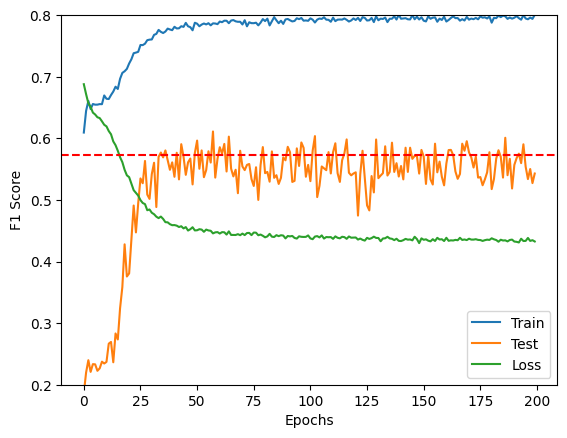

In [275]:
# PARAMS
params = {
    "SAMPLER_SIZES": [15, 10, 5],
    "SAMPLER_BATCH_SIZE": 8,
    "MODEL_HIDDEN_CHANNELS": 258,
    "MODEL_NUM_LAYERS": 3,
    "NUM_EPOCHS": 200,
    "LEARNING_RATE": 0.00003,
    "DROPOUT": 0.6,
    "WEIGHT_DECAY": 7e-3,
}

png_filename = f'data/plot_final.png'
model_fit(params, png_filename)